In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

In [ ]:
print("PyTorch version:", torch.__version__)
print("torchvision version:", torchvision.__version__)

PyTorch version: 2.4.1+cu121
torchvision version: 0.19.1+cu121


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
# torch.set_default_device(device)

In [ ]:
cifar10 = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)


class_names = cifar10.classes
print(class_names)

100%|██████████| 170498071/170498071 [00:06<00:00, 27501864.09it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [ ]:
def get_dataloader(transform: torchvision.transforms,
                   batch_size: int,
                   num_workers: int):
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

    train_dataloader = DataLoader(dataset= trainset, batch_size = batch_size, shuffle= True, num_workers = num_workers)
    test_dataloader = DataLoader(dataset= testset, batch_size = batch_size, shuffle= False, num_workers = num_workers)

    return train_dataloader, test_dataloader

In [ ]:
import os
num_workers = os.cpu_count()

simple_transforms = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

simple_cnn_train_dataloader, simple_cnn_test_dataloader = get_dataloader(simple_transforms, 32, num_workers)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
import random

def inspect_images(dataloader: torch.utils.data.DataLoader,
                   k: int,
                   seed = 42):
    batch = next(iter(dataloader))
    images, labels = batch

    image_list = [img for img in images]
    label_list = [label for label in labels]
    torch.manual_seed(42)
    random.seed(42)

    combined = list(zip(image_list, label_list))
    random_samples = random.sample(combined, k)

    fig, axs = plt.subplots(1,5, figsize=(15,3))

    for ax, (img, label) in zip(axs, random_samples):
      ax.imshow(img.permute(1,2,0))
      ax.set_title(f'Label: {class_names[label]}')
      ax.axis('off')

    plt.tight_layout()
    plt.show()

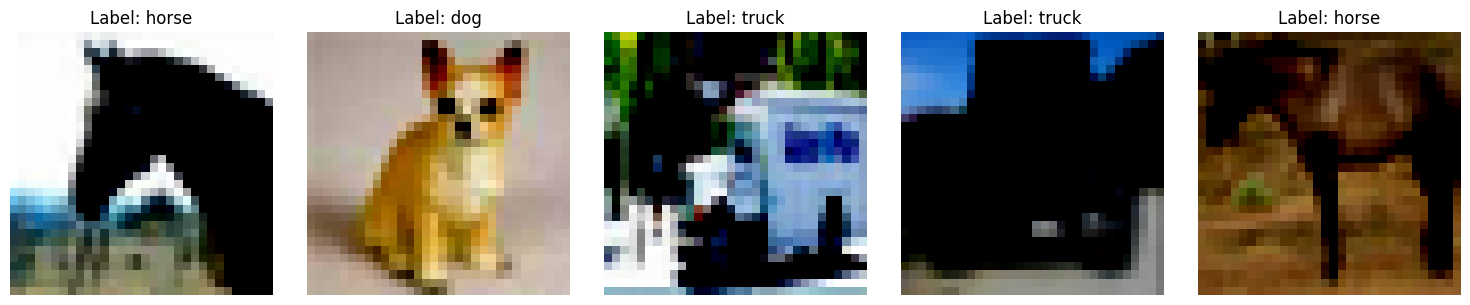

In [ ]:
inspect_images(simple_cnn_train_dataloader,
               5)

In [ ]:
class CNN(nn.Module):
  def __init__(self,
               input_shape : int,
               output_shape: int,
               hidden_units: int):
    super().__init__()
    self.block1 = nn.Sequential(
        nn.Conv2d(in_channels = input_shape,
                  out_channels = hidden_units,
                  kernel_size = 2,
                  padding = 1,
                  stride = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 2,
                  padding = 1,
                  stride = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2,
                     stride = 2)
    )
    self.block2 = nn.Sequential(
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 2,
                  padding = 1,
                  stride = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 2,
                  padding = 1,
                  stride = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2,
                     stride = 2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = 10*9*9,
                  out_features = output_shape)
    )
  def forward(self, x):
    return self.classifier(self.block2(self.block1(x)))

cnn = CNN(3, 10, 10).to(device)
# cnn = torch.compile(cnn)
dummy_tensor = torch.rand(size=(3,32,32))
y_logits = cnn(dummy_tensor.unsqueeze(dim = 0).to(device))
print(y_logits.detach().cpu().numpy())

[[ 0.02067235  0.02901347 -0.02579954 -0.04881421  0.02768324 -0.05796953
   0.04800495 -0.01116066 -0.04456091  0.0135883 ]]


In [ ]:
def initialize_lossfn_and_optimizer(model: torch.nn.Module):
    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(params = model.parameters(),
                                 lr = 0.001)
    return loss_fn, optimizer

In [ ]:
def train_model(trainloader: torch.utils.data.DataLoader,
                testloader: torch.utils.data.DataLoader,
                model: torch.nn.Module,
                loss_fn : torch.nn.Module,
                optimizer : torch.optim.Optimizer,
                epochs : int = 3,
                device = device,
                seed = 42):
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  model.train()
  for epoch in range(epochs):
      print(f'epoch {epoch+1}')
      train_loss = 0
      for i, (X, y) in enumerate(trainloader):
          X, y = X.to(device), y.to(device)
          y_logits = model(X)
          loss = loss_fn(y_logits, y)
          train_loss += loss
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

      train_loss /= len(trainloader)

      test_loss, test_acc = 0, 0
      model.eval()
      with torch.inference_mode():
        for X,y in testloader:
          X, y = X.to(device), y.to(device)
          y_logits = model(X)
          loss = loss_fn(y_logits, y)
          test_loss += loss
          y_pred = torch.argmax(y_logits, dim = 1)
          correct = torch.eq(y_pred, y).sum().item()
          acc = correct / len(y_pred) * 100
          test_acc += acc

        test_loss /= len(testloader)
        test_acc /= len(testloader)

      print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")

In [ ]:
simple_cnn_loss_fn, simple_cnn_optimizer = initialize_lossfn_and_optimizer(model = cnn)

train_model(trainloader = simple_cnn_train_dataloader,
            testloader = simple_cnn_test_dataloader,
            model= cnn,
            loss_fn = simple_cnn_loss_fn,
            optimizer= simple_cnn_optimizer,
            epochs= 3,
            device= device,
            seed = 42)

In [ ]:
try:
  from torchinfo import summary
except:
  !pip install torchinfo
  from torchinfo import summary

In [ ]:
def summarize_model(model):
    model_summary = summary(model= model,
            input_size= (1,3,224,224),
            col_names=['input_size', 'output_size','num_params','trainable'],
            col_width= 20,
            verbose= 0,
            row_settings= ['var_names'])

    print(model_summary)

In [ ]:
def create_alexnet(class_names):
    weights = torchvision.models.AlexNet_Weights.DEFAULT
    model = torchvision.models.alexnet(weights = weights)
    transform = weights.transforms()

    for param in model.parameters():
        param.requires_grad = False

    model.classifier = nn.Sequential(
        nn.Dropout(p=0.5, inplace=False),
        nn.Linear(in_features=9216, out_features=4096, bias=True),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.5, inplace=False),
        nn.Linear(in_features=4096, out_features=4096, bias=True),
        nn.ReLU(inplace=True),
        nn.Linear(in_features=4096, out_features=len(class_names), bias=True)
    )

    return model, transform

In [ ]:
alexnet, alexnet_transform = create_alexnet(class_names)
summarize_model(alexnet)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 130MB/s]


Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
AlexNet (AlexNet)                        [1, 3, 224, 224]     [1, 10]              --                   Partial
├─Sequential (features)                  [1, 3, 224, 224]     [1, 256, 6, 6]       --                   False
│    └─Conv2d (0)                        [1, 3, 224, 224]     [1, 64, 55, 55]      (23,296)             False
│    └─ReLU (1)                          [1, 64, 55, 55]      [1, 64, 55, 55]      --                   --
│    └─MaxPool2d (2)                     [1, 64, 55, 55]      [1, 64, 27, 27]      --                   --
│    └─Conv2d (3)                        [1, 64, 27, 27]      [1, 192, 27, 27]     (307,392)            False
│    └─ReLU (4)                          [1, 192, 27, 27]     [1, 192, 27, 27]     --                   --
│    └─MaxPool2d (5)                     [1, 192, 27, 27]     [1, 192, 13, 13]     --                   --
│    └─Conv2d (6

In [ ]:
alexnet_traindataloader, alexnet_testdataloader = get_dataloader(transform= alexnet_transform,
                                                                    batch_size= 32,
                                                                    num_workers= num_workers)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
alexnet_lossfn, alexnet_optimizer = initialize_lossfn_and_optimizer(model =  alexnet)

In [ ]:
train_model(trainloader = alexnet_traindataloader,
            testloader = alexnet_testdataloader,
            model= alexnet,
            loss_fn = alexnet_lossfn,
            optimizer= alexnet_optimizer,
            epochs= 3,
            device= device,
            seed = 42)

In [ ]:
def create_vgg(class_names):
  weights = torchvision.models.VGG11_Weights.DEFAULT
  model = torchvision.models.vgg11(weights = weights)
  transform = weights.transforms()

  for param in model.parameters():
    param.requires_grad = False

  model.classifier = nn.Sequential(
      nn.Linear(in_features=25088, out_features=4096, bias=True),
      nn.ReLU(inplace=True),
      nn.Dropout(p=0.5, inplace=False),
      nn.Linear(in_features=4096, out_features=4096, bias=True),
      nn.ReLU(inplace=True),
      nn.Dropout(p=0.5, inplace=False),
      nn.Linear(in_features=4096, out_features=len(class_names), bias=True)
  )

  return model, transform

In [ ]:
vgg, vgg_transform = create_vgg(class_names)

In [ ]:
summarize_model(vgg)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
VGG (VGG)                                [1, 3, 224, 224]     [1, 10]              --                   Partial
├─Sequential (features)                  [1, 3, 224, 224]     [1, 512, 7, 7]       --                   False
│    └─Conv2d (0)                        [1, 3, 224, 224]     [1, 64, 224, 224]    (1,792)              False
│    └─ReLU (1)                          [1, 64, 224, 224]    [1, 64, 224, 224]    --                   --
│    └─MaxPool2d (2)                     [1, 64, 224, 224]    [1, 64, 112, 112]    --                   --
│    └─Conv2d (3)                        [1, 64, 112, 112]    [1, 128, 112, 112]   (73,856)             False
│    └─ReLU (4)                          [1, 128, 112, 112]   [1, 128, 112, 112]   --                   --
│    └─MaxPool2d (5)                     [1, 128, 112, 112]   [1, 128, 56, 56]     --                   --
│    └─Conv2d (6

In [ ]:
vgg_traindataloader, vgg_testdataloader = get_dataloader(transform = vgg_transform,
                                                         batch_size = 32,
                                                         num_workers = num_workers)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
vgg_loss_fn, vgg_optimizer = initialize_lossfn_and_optimizer(vgg)

train_model(trainloader = vgg_traindataloader,
            testloader = vgg_testdataloader,
            model= vgg,
            loss_fn = vgg_loss_fn,
            optimizer= vgg_optimizer,
            epochs= 3,
            device= device,
            seed = 42)

epoch 1

Train loss: 0.93343 | Test loss: 0.61630, Test acc: 79.49%

epoch 2

Train loss: 0.33287 | Test loss: 0.44874, Test acc: 85.93%

epoch 3

Train loss: 0.16856 | Test loss: 0.58923, Test acc: 84.72%



In [ ]:
def create_resnet(class_names):
  weights = torchvision.models.ResNet18_Weights.DEFAULT
  model = torchvision.models.resnet18(weights = weights)
  transform = weights.transforms()

  for param in model.parameters():
    param.requires_grad = False

  model.fc = nn.Linear(in_features = 512, out_features = len(class_names), bias = True)

  return model, transform

In [ ]:
resnet, resnet_transform = create_resnet(class_names)

In [ ]:
summarize_model(resnet)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [1, 3, 224, 224]     [1, 10]              --                   Partial
├─Conv2d (conv1)                         [1, 3, 224, 224]     [1, 64, 112, 112]    (9,408)              False
├─BatchNorm2d (bn1)                      [1, 64, 112, 112]    [1, 64, 112, 112]    (128)                False
├─ReLU (relu)                            [1, 64, 112, 112]    [1, 64, 112, 112]    --                   --
├─MaxPool2d (maxpool)                    [1, 64, 112, 112]    [1, 64, 56, 56]      --                   --
├─Sequential (layer1)                    [1, 64, 56, 56]      [1, 64, 56, 56]      --                   False
│    └─BasicBlock (0)                    [1, 64, 56, 56]      [1, 64, 56, 56]      --                   False
│    │    └─Conv2d (conv1)               [1, 64, 56, 56]      [1, 64, 56, 56]      (36,864)             False
│    │    

In [ ]:
resnet_traindataloader, resnet_testdataloader = get_dataloader(transform = resnet_transform,
                                                               batch_size = 32,
                                                               num_workers = num_workers)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
resnet_lossfn, resnet_optimizer = initialize_lossfn_and_optimizer(resnet)

train_model(trainloader = resnet_traindataloader,
            testloader = resnet_testdataloader,
            model= resnet,
            loss_fn = resnet_lossfn,
            optimizer= resnet_optimizer,
            epochs= 3,
            device= device,
            seed = 42)

epoch 1

Train loss: 0.89060 | Test loss: 0.69025, Test acc: 76.50%

epoch 2

Train loss: 0.65760 | Test loss: 0.66481, Test acc: 77.13%

epoch 3

Train loss: 0.63317 | Test loss: 0.65748, Test acc: 77.13%



In [ ]:
def create_googlenet(class_names):
  weights = torchvision.models.GoogLeNet_Weights.DEFAULT
  model = torchvision.models.googlenet(weights = weights)
  transform = weights.transforms()

  for param in model.parameters():
    param.requires_grad = False

  model.fc = nn.Linear(in_features=1024, out_features=len(class_names), bias=True)

  return model, transform

In [ ]:
googlenet, googlenet_transform = create_googlenet(class_names)

In [ ]:
summarize_model(googlenet)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
GoogLeNet (GoogLeNet)                    [1, 3, 224, 224]     [1, 10]              --                   Partial
├─BasicConv2d (conv1)                    [1, 3, 224, 224]     [1, 64, 112, 112]    --                   False
│    └─Conv2d (conv)                     [1, 3, 224, 224]     [1, 64, 112, 112]    (9,408)              False
│    └─BatchNorm2d (bn)                  [1, 64, 112, 112]    [1, 64, 112, 112]    (128)                False
├─MaxPool2d (maxpool1)                   [1, 64, 112, 112]    [1, 64, 56, 56]      --                   --
├─BasicConv2d (conv2)                    [1, 64, 56, 56]      [1, 64, 56, 56]      --                   False
│    └─Conv2d (conv)                     [1, 64, 56, 56]      [1, 64, 56, 56]      (4,096)              False
│    └─BatchNorm2d (bn)                  [1, 64, 56, 56]      [1, 64, 56, 56]      (128)                False
├─Basic

In [ ]:
googlenet_traindataloader, googlenet_testdataloader = get_dataloader(transform = googlenet_transform,
                                                                     batch_size = 32,
                                                                     num_workers = num_workers)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
googlenet_lossfn, googlenet_optimizer = initialize_lossfn_and_optimizer(googlenet)

train_model(trainloader = googlenet_traindataloader,
            testloader = googlenet_testdataloader,
            model= googlenet,
            loss_fn = googlenet_lossfn,
            optimizer= googlenet_optimizer,
            epochs= 3,
            device= device,
            seed = 42)

epoch 1

Train loss: 0.94441 | Test loss: 0.71594, Test acc: 75.67%

epoch 2

Train loss: 0.64677 | Test loss: 0.65456, Test acc: 77.34%

epoch 3

Train loss: 0.60964 | Test loss: 0.66142, Test acc: 77.07%

